In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import torchvision.utils as utils
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm_notebook as tqdm


In [2]:
# Saving model in Google Drive
"""
from google.colab import drive
drive.mount('/content/gdrive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

In [0]:
#Parameters
epoch = 10
batch_size = 128
learning_rate = 0.001
decay_rate = 0.9
image_size = 64
noise_size = 100 #dimension of latent vector z
num_classes = 10

input_g_size = noise_size + num_classes



In [6]:
# Incorporate Wikiart
"""
class WikiartDataset(Dataset):

    def _init_(self, type, file, dir, mode, transform):

        #:param type: 0: Style, 1: Genre, 2: Artist
        #:param file: .csv file that contains the path and classification
        #:param dir: directory of the image files
        #:param mode: 'Train' or 'Test'
        #:param transform: image transformation

        self.type = type
        self.dir = dir
        self.df = pd.read_csv(os.path.join(self.dir, file), header=None, names=["file", "label"])
        self.mode = mode
        self.transform = transform

    def _len_(self):
        return len(self.df)

    def _str_(self):
        text = "Type: "
        if self.type == 0:
            text += "Style"
        elif self.type == 1:
            text += "Genre"
        elif self.type == 2:
            text += "Artist"
        text += ", mode: "
        text += self.mode
        text += ", number of files: "
        text += str(len(self.df))
        return text

    def _getitem_(self, idx):
        file = self.df.loc[idx, "file"]
        label = self.df.loc[idx, "label"]
        img = Image.open(os.path.join(self.dir, file))
        img = self.transform(img)
        return img, label

"""

'\nclass WikiartDataset(Dataset):\n\n    def _init_(self, type, file, dir, mode, transform):\n\n        :param type: 0: Style, 1: Genre, 2: Artist\n        :param file: .csv file that contains the path and classification\n        :param dir: directory of the image files\n        :param mode: \'Train\' or \'Test\'\n        :param transform: image transformation\n\n        self.type = type\n        self.dir = dir\n        self.df = pd.read_csv(os.path.join(self.dir, file), header=None, names=["file", "label"])\n        self.mode = mode\n        self.transform = transform\n\n    def _len_(self):\n        return len(self.df)\n\n    def _str_(self):\n        text = "Type: "\n        if self.type == 0:\n            text += "Style"\n        elif self.type == 1:\n            text += "Genre"\n        elif self.type == 2:\n            text += "Artist"\n        text += ", mode: "\n        text += self.mode\n        text += ", number of files: "\n        text += str(len(self.df))\n        return t

Extracting ./data/cifar-10-python.tar.gz to ./data


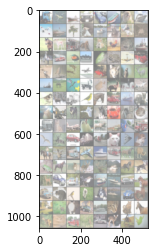

In [7]:
#Getting our data set
#CIFAR-10
torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.Resize(size=(image_size, image_size)),
     transforms.ToTensor(),
])


trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
class Discriminator(nn.Module):
  def __init__(self,input_dim=3):
    #input_size = size of the input image
    #input_dim = number of channels of the input image

    super(Discriminator, self).__init__()
    #input image 3@64x64
    self.conv1 = nn.Conv2d(input_dim,128,4,stride=2,padding=1)
    #size 128@32x32
    self.conv2 = nn.Conv2d(128,128,3,stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(128)
    #size 128@32x32
    self.conv3 = nn.Conv2d(128,256,4,stride=2,padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    #size 256@16x16
    self.conv4 = nn.Conv2d(256,512,4,stride=2,padding=1)
    self.bn3 = nn.BatchNorm2d(512)
    #size 512@8x8
    self.conv5 = nn.Conv2d(512,1024,4,stride=2,padding=1)
    self.bn4 = nn.BatchNorm2d(1024)
    #size 1024@4x4

    out_size = 1024*4*4

    self.fc6 = nn.Linear(out_size, num_classes+1) 

    self.leakyReLU = nn.LeakyReLU(0.2,inplace=True)


  def forward(self,x):
    out = self.leakyReLU(self.conv1(x))
    out = self.leakyReLU(self.bn1(self.conv2(out)))
    out = self.leakyReLU(self.bn2(self.conv3(out)))
    out = self.leakyReLU(self.bn3(self.conv4(out)))
    out = self.leakyReLU(self.bn4(self.conv5(out)))

    out = out.view(out.size(0),-1)
    out = self.fc6(out)
    out = torch.sigmoid(out)

    return out

  def encoder(self,x):
    out = self.leakyReLU(self.conv1(x))
    out = self.leakyReLU(self.bn1(self.conv2(out)))
    out = self.leakyReLU(self.bn2(self.conv3(out)))
    out = self.leakyReLU(self.bn3(self.conv4(out)))

    return out



In [0]:
class Generator(nn.Module):
  def __init__(self,input_size=input_g_size):
    #input_size = input vector size 

    super(Generator, self).__init__()
    #input is noise vector z and label vector y concataneted
    self.conv1 = nn.ConvTranspose2d(input_size,1024,4,stride=1,padding=0)
    self.bn1 = nn.BatchNorm2d(1024)
    #size 1024@4x4
    self.conv2 = nn.ConvTranspose2d(1024,512,4,stride=2,padding=1)
    self.bn2 = nn.BatchNorm2d(512)
    #size 512@8x8
    self.conv3 = nn.ConvTranspose2d(512,256,4,stride=2,padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    #size 256@16x16
    self.conv4 = nn.ConvTranspose2d(256,128,4,stride=2,padding=1)
    self.bn4 = nn.BatchNorm2d(128)
    #size 128@32x32
    self.conv5 = nn.ConvTranspose2d(128,128,3,stride=1,padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    #size 128@32x32
    self.conv6 = nn.ConvTranspose2d(128,3,4,stride=2,padding=1)
    #size 3@64x64

    self.input_size = input_size


  def forward(self,x):

    out = x.view(-1, self.input_size, 1, 1)
    out = F.relu(self.bn1(self.conv1(out)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = F.relu(self.bn3(self.conv3(out)))
    out = F.relu(self.bn4(self.conv4(out)))
    out = F.relu(self.bn5(self.conv5(out)))
    out = torch.sigmoid(self.conv6(out))

    return out

  def decoder(self,x):

    out = F.relu(self.bn3(self.conv3(x)))
    out = F.relu(self.bn4(self.conv4(out)))
    out = F.relu(self.bn5(self.conv5(out)))
    out = torch.sigmoid(self.conv6(out))

    return out



In [0]:
def noise_z(noise_size=noise_size,batch_size=batch_size):
  z = torch.randn(batch_size, noise_size) #creates z input to G
  return z

def label(num_classes=num_classes,batch_size=batch_size): 
  y = torch.zeros(batch_size, num_classes)  #creates a random label vector input to G
  for i in range(batch_size):
    j = np.random.randint(0,num_classes)
    y[i][j] = 1

  return y

#Noise + label fixed to visualize G's progress
z = noise_z()
y = label()
noise_label = torch.cat([z,y],1).type(torch.cuda.FloatTensor)

#Decay learning rate
def exp_lr_scheduler(optimizer, decay_rate=0.9):
  """
    lr = learning_rate * (0.1 ** (epoch // lr_decay_epoch))
    print('LR is set to {}'.format(lr))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
  """
  optimizer_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

  return optimizer_scheduler

#Randomly flip some true labels into fake 
def labels_flip(y, p_flip):
  # determine the number of labels to flip
  n_select = int(p_flip * y.shape[0])
  for i in range(n_select):
    j = np.random.randint(0,y.shape[0])
    y[j] = 10
  return y

#Randomly flip some fake labels into true
def labels_flip_fake(y, p_flip):
  # determine the number of labels to flip
  n_select = int(p_flip * y.shape[1])
  for i in range(n_select):
    j = np.random.randint(0,y.shape[1])
    k = np.random.randint(0,10)
    y[0][j] = k
  return y

#Noise to the real image 
def noise_image(epoch,batch_size=128):
  noise = torch.normal(0.0, 0.1/(epoch+1), size=(batch_size, 3, 64, 64))
  return noise


#Fake label to use in the D loss (num_classes is the label of the fake class - for cifar-10 is 10)
f = torch.full((1,batch_size), num_classes,dtype=int)
f_fliped = labels_flip_fake(f,0.05)
f_onehot = F.one_hot(f_fliped,num_classes +1)


In [0]:
#We define our D and G nets
D_net = Discriminator()
G_net = Generator()

In [0]:
def train(D_net,G_net,optimizer_D,optimizer_G,D_scheduler,G_scheduler,train_loader, n_epoch = epoch,
          noise_label=noise_label,f_onehot=f_onehot,
          cuda=True):

  #f_onehot = fake label
  #noise_label = input to record G's progress

  loss_D = []
  loss_G = []
  img = []
  total = 0
  if cuda:
    f_onehot = f_onehot.type(torch.cuda.FloatTensor) #fake label
    noise_label = noise_label.type(torch.cuda.FloatTensor) #noise label vector

  for epoch in range(n_epoch):  # loop over the dataset multiple times

      D_scheduler.step()
      G_scheduler.step()

      for i, data in enumerate(tqdm(train_loader), 0):

          if i == len(train_loader) - 1:   #maracutaia pra não dar pau no último caso - arrumar depois
            break

          # get the inputs
          inputs, labels = data

          # put noise on the image
          noise = noise_image(epoch)
          inputs += noise

          # flip some labels to prevent overfit
          label_fliped = labels_flip(labels, 0.05)

          # transform labels in one-hot vectors
          """
          labels = labels.view(-1,1)
          labels_onehot = torch.LongTensor(batch_size, num_classes+1)
          labels_onehot.zero_()
          labels_onehot.scatter_(1,labels,1)
          """

          labels_onehot = F.one_hot(label_fliped,num_classes + 1)

          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels_onehot = labels_onehot.type(torch.cuda.FloatTensor)

          # zero the parameter gradients for D
          optimizer_D.zero_grad()

          # feed D with real batch
          output_real = D_net(inputs)

          # generate fake batch
          z = noise_z()
          y = label()
          if cuda:
            z = z.type(torch.cuda.FloatTensor)
            y = y.type(torch.cuda.FloatTensor)
          input_G = torch.cat([z,y],1)
          fake_batch = G_net(input_G)

          # feed D with fake batch and computate the D loss comparing with fake label
          output_fake = D_net(fake_batch)

          # computate loss in the real batch and in the fake batch
          lossD_real = F.binary_cross_entropy(output_real, labels_onehot)
          lossD_fake = F.binary_cross_entropy(output_fake,f_onehot)
          lossD = lossD_real + lossD_fake
          lossD.backward(retain_graph=True)
          optimizer_D.step()

          # zero the parameter gradients for G
          #optimizer_G.zero_grad()
          G_net.zero_grad()

          # feed D with fake batch (now that D is updated)
          output_fake2 = D_net(fake_batch)

          # in the G loss we compare the fake output with the real image label - y
          # as y is of size K, we got to make it K+1 to compare with fake output
          """
          zero = torch.zeros(batch_size,1)
          y_ = torch.reshape(y,(batch_size,num_classes))
          y_final = torch.cat((y_,zero),1)
          if cuda:
            y_final = y_final.type(torch.cuda.FloatTensor)
          """
          y_ = torch.cat([y,torch.zeros(batch_size,1).type(torch.cuda.FloatTensor)],1)

          # Reconstruct the image to use the loss L2
          enc = D_net.encoder(inputs)
          dec = G_net.decoder(enc)

          # computate the G loss
          lossG = F.binary_cross_entropy(output_fake2,y_) + torch.mean((dec - inputs) ** 2)
          lossG.backward()
          optimizer_G.step()

          #Save losses
          loss_D.append(lossD.item())
          loss_G.append(lossG.item())

          # print statistics
          if i % 50 == 0: 
            print('[%d/%d][%d/%d]\tLoss_D: %.3f\tLoss_G: %.3f' % (epoch, n_epoch,
                                                                  i,len(train_loader),
                                                                  lossD.item(),lossG.item()))

      # check the images the generator is creating at each epoch
      x = G_net(noise_label).detach().cpu()
      with torch.no_grad():
        for i in range(0,20):
          test = plt.figure()
          plt.imshow(x[i].permute(1, 2, 0))
          plt.show()
      img.append(utils.make_grid(x,normalize=True))

  return  img, loss_D, loss_G

In [0]:
#Adam optimizers for D and G
optimizer_D = torch.optim.RMSprop(D_net.parameters(), lr=learning_rate, alpha=0.9)

optimizer_G = torch.optim.RMSprop(G_net.parameters(), lr=learning_rate, alpha=0.9)

D_scheduler = exp_lr_scheduler(optimizer_D)
G_scheduler = exp_lr_scheduler(optimizer_G)

In [14]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    D_net.cuda()
    G_net.cuda()

using cuda


In [0]:
#training with flip labels and noise 

img, loss_D, loss_G = train(D_net,G_net,optimizer_D,optimizer_G,D_scheduler,G_scheduler,trainloader)

In [0]:
#getting saved models
"""
Generator_noise = 'Generator_noise.pt'
path = F"/content/gdrive/My Drive/{Generator_noise}"
G_net.load_state_dict(torch.load(path))

Discriminator_noise = 'Discriminator_noise.pt'
path = F"/content/gdrive/My Drive/{Discriminator_noise}"
D_net.load_state_dict(torch.load(path))
"""

<All keys matched successfully>

In [0]:
 #saving models 
"""
Generator_noise = 'Generator_noise.pt'
path = F"/content/gdrive/My Drive/{Generator_noise}" 
torch.save(G_net.state_dict(), path)

Discriminator_noise = 'Discriminator_noise.pt'
path = F"/content/gdrive/My Drive/{Discriminator_noise}" 
torch.save(D_net.state_dict(), path)
"""

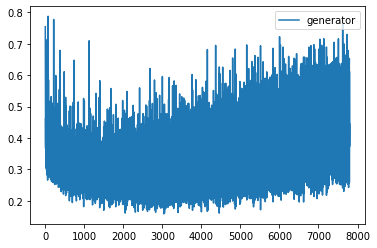

In [0]:
plt.plot(loss_G,label='generator')
plt.show
plt.legend(loc=1)


In [0]:
plt.plot(loss_D,label='discriminator')
plt.show
plt.legend(loc=1)

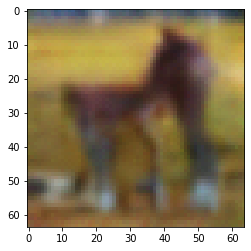

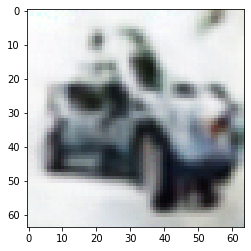

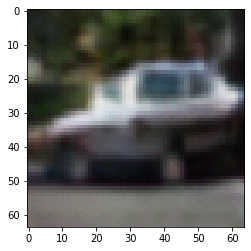

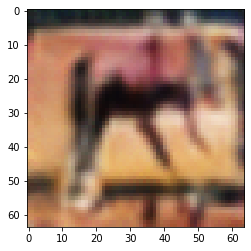

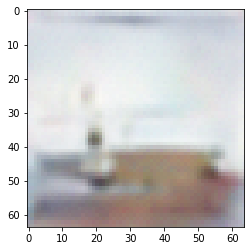

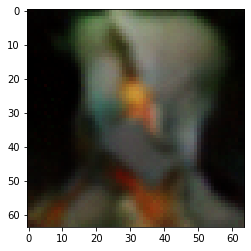

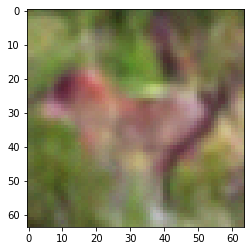

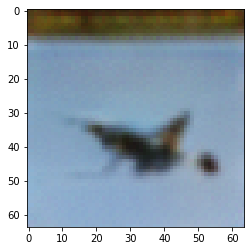

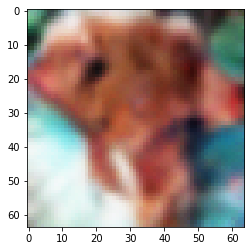

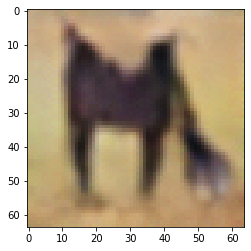

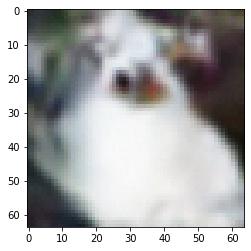

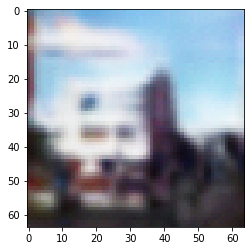

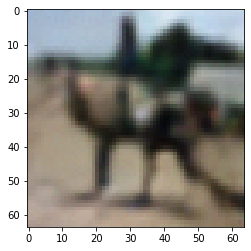

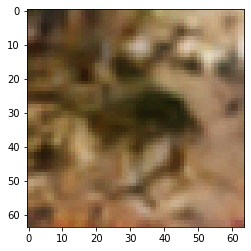

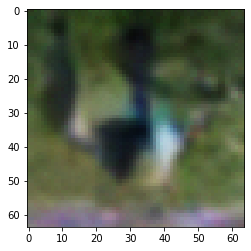

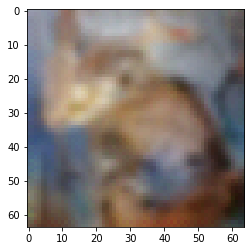

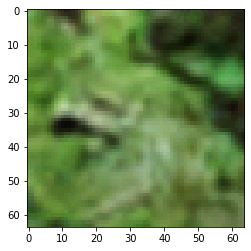

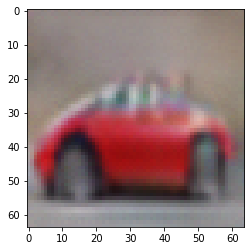

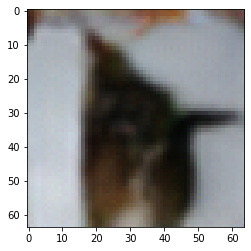

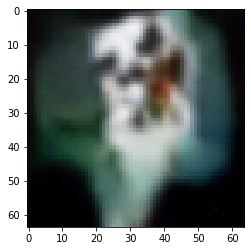

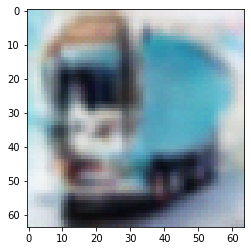

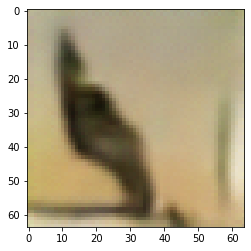

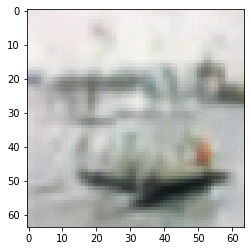

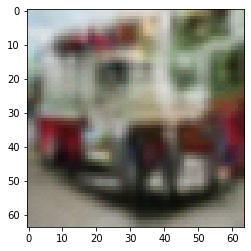

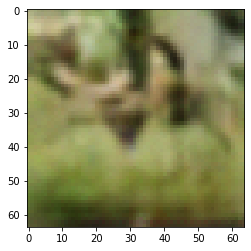

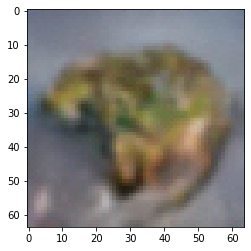

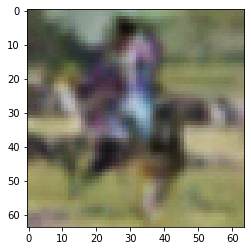

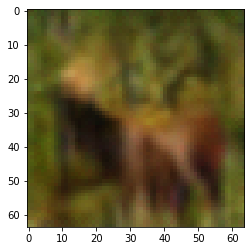

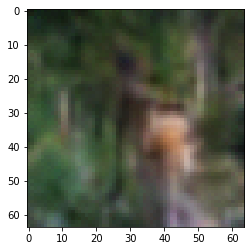

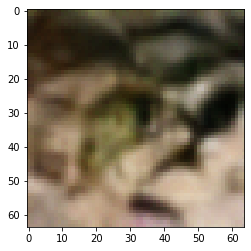

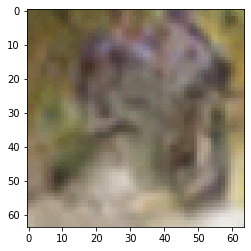

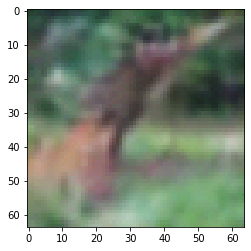

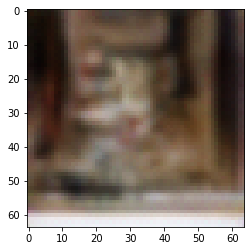

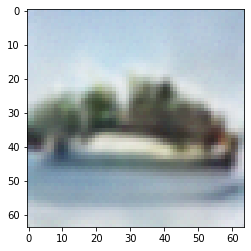

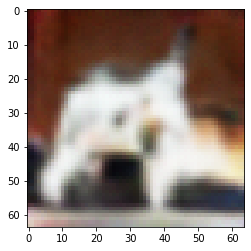

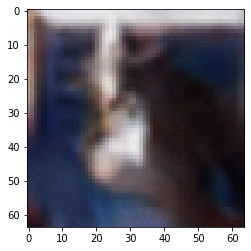

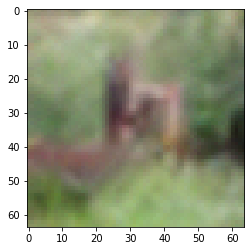

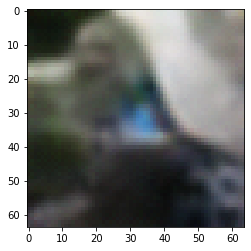

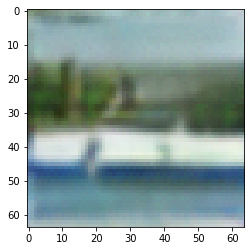

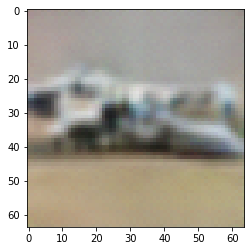

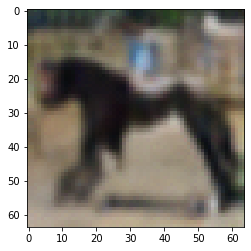

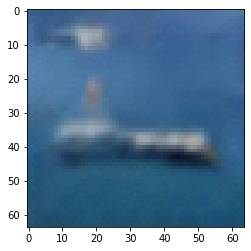

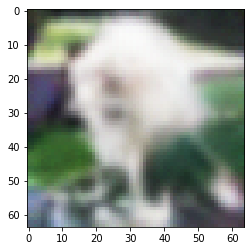

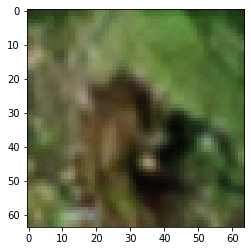

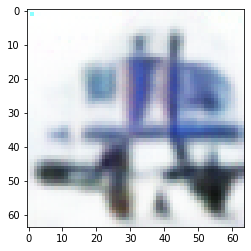

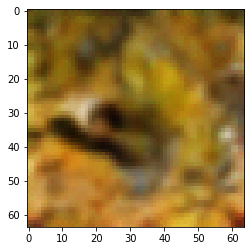

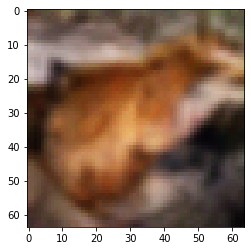

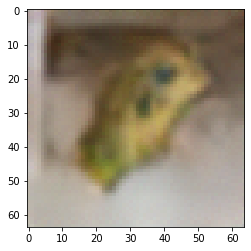

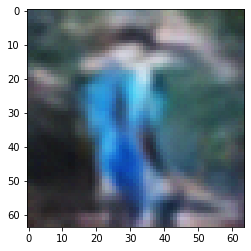

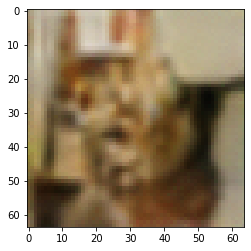

In [0]:
# to test G 
x = G_net(noise_label).detach().cpu()

with torch.no_grad():
  for i in range(50):
    plt.imshow(x[i+50].permute(1, 2, 0))
    plt.show()
